# Linear Regression and Submission for [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)
---
### Summary

[**1. Load, Merge and Clean the Dataset**](#1.-Load,-Merge-and-Clean-the-Dataset)

[**2. Feature Engineering**](#2.-Feature-Engineering)
- 2.1 Feature Creation: convert `'visit_date'` into numeric variables
- 2.2 Feature Creation: cluster restaurants based on activity
- ~~2.3 Feature Creation: cluster restaurants based on geographical coordinates~~
- ~~2.4 Feature Creation: convert restaurant ID's into numeric variables~~
- ~~2.5 Feature Creation: average daily visitors~~
- ~~2.6 Update missing `'reservations'`~~
- 2.7 Feature Selection: check correlation between `short_df` features
- 2.8 Feature Selection (Univariate): evaluate features based on the level of association with its target
- 2.9 Feature Selection (Univariate): choose features based on their effective contribution

[**3. Linear Regression**](#3.-Linear-Regression)
- 3.1 Split Data into Train and Test Sets
- 3.2 Cross-Validation: Linear Regression
- 3.3 Cross-Validation: Ridge (regularized regression)
- 3.4 Cross-Validation: Lasso (regularized regression)
- 3.5 Visualize Coefficients for Feature Selection
- 3.6 Compare Actual Visitation Data vs Predicted

[**4. Random Forest**](#4.-Random-Forest)
- 4.1 Visualize Feature Importances
- 4.2 Compare Actual Visitation Data vs Predicted

[**5. Gradient Boosting Regression**](#5.-Gradient-Boosting-Regression)

[**6. Kaggle Submission**](#6.-Kaggle-Submission)

---

# 1. Load, Merge and Clean the Dataset

In [1]:
# load all datasets, then merge and clean them to be used:
from lib import clean_db

full_df = clean_db.load_from('data')                      # 'data': directory that contains .csv files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

full_df.visit_date = pd.to_datetime(full_df.visit_date)   # Convert column visit_date to Datetime object

A Jupyter Widget

# 2. Feature Engineering

First, check the correlation between *original* `full_df` features:

>>> There are 829 different restaurants.
>>> full_df shape= (255917, 10)


,air_store_id,visit_date,visitors,genre_name,area_name,latitude,longitude,reservations,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Friday,0


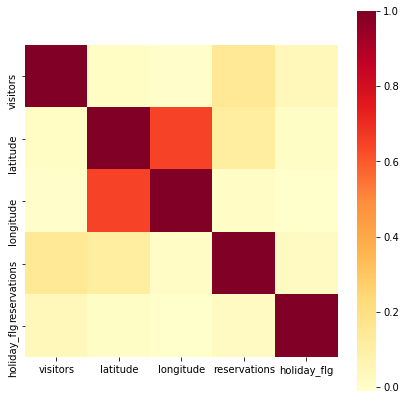

In [2]:
print('>>> There are', len(full_df.air_store_id.unique()), 'different restaurants.')
print('>>> full_df shape=', full_df.shape)
display(full_df.head(3))

# Plot correlation between different features
plt.figure(figsize=(7, 7))
sns.heatmap(full_df.corr(), square=True, cmap='YlOrRd') # RdBu_r, YlOrRd
plt.plot()
plt.show()

### 2.1 Feature Creation: convert `'visit_date'` into numeric variables

`short_df` is the resulting DataFrame, created to store all the features used for linear regression later on. 

In [3]:
# Select which features are going to be used from the Dataframe
def get_features_df():
#     short_df = full_df[ ['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg', 'reservations'] ].copy()
#     short_df = full_df[ ['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg', 'reservations', 'latitude', 'longitude', 'genre_name'] ].copy()
    short_df = full_df[ ['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg', 'reservations', 'latitude', 'longitude'] ].copy()

    short_df['year'] = full_df['visit_date'].dt.year
    short_df['month'] = full_df['visit_date'].dt.month
    short_df['day'] = full_df['visit_date'].dt.day

    # Convert 'day_of_week' categorical feature into dummy variable
    short_df = pd.get_dummies(short_df, columns=['day_of_week'])
    
    # Convert 'genre_name' categorical feature into dummy variable
#     short_df = pd.get_dummies(short_df, columns=['genre_name'])
    
    return short_df


short_df = get_features_df()
print('>>> get_features_df() shape=', short_df.shape)
print('>>> get_features_df() cols=', short_df.columns)
display(short_df.head(3))

>>> get_features_df() shape= (255917, 17)
>>> get_features_df() cols= Index(['air_store_id', 'visit_date', 'visitors', 'holiday_flg', 'reservations',
       'latitude', 'longitude', 'year', 'month', 'day', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')


,air_store_id,visit_date,visitors,holiday_flg,reservations,latitude,longitude,year,month,day,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,air_ba937bf13d40fb24,2016-01-13,25,0,-1.0,35.658068,139.751599,2016,1,13,0,0,0,0,0,0,1
1,air_ba937bf13d40fb24,2016-01-14,32,0,-1.0,35.658068,139.751599,2016,1,14,0,0,0,0,1,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0,-1.0,35.658068,139.751599,2016,1,15,1,0,0,0,0,0,0


### 2.2 Feature Creation: daily visitors statistics per day of the week

Restaurants are grouped by ID and day of the week to compute statistics based on visitors information, such as: min, max, mean, median and number of observations.

In [4]:
short_df.visit_date = pd.to_datetime(short_df.visit_date)
short_df['dow'] = short_df['visit_date'].apply(lambda x: x.weekday())  # Monday=0, Sunday=6
#display(short_df.head())

# Compute min(), max(), mean() median() and size() for every restaurant per day of the week
tmp = short_df.groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
display(tmp.head())

short_df = pd.merge(short_df, tmp, how='left', on=['air_store_id','dow']) 
display(short_df.head())

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1,22.457143,19.0,47,35
1,air_00a91d42b08b08d9,1,1,24.350000,24.5,43,40
2,air_00a91d42b08b08d9,2,15,28.125000,28.0,52,40
3,air_00a91d42b08b08d9,3,15,29.868421,30.0,47,38
4,air_00a91d42b08b08d9,4,17,36.500000,35.5,57,40


,air_store_id,visit_date,visitors,holiday_flg,reservations,latitude,longitude,year,month,day,...,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_ba937bf13d40fb24,2016-01-13,25,0,-1.0,35.658068,139.751599,2016,1,13,...,0,0,0,1,2,7,23.843750,25.0,57,64
1,air_ba937bf13d40fb24,2016-01-14,32,0,-1.0,35.658068,139.751599,2016,1,14,...,0,1,0,0,3,2,20.292308,21.0,54,65
2,air_ba937bf13d40fb24,2016-01-15,29,0,-1.0,35.658068,139.751599,2016,1,15,...,0,0,0,0,4,4,34.738462,35.0,61,65
3,air_ba937bf13d40fb24,2016-01-16,22,0,-1.0,35.658068,139.751599,2016,1,16,...,0,0,0,0,5,6,27.651515,27.0,53,66
4,air_ba937bf13d40fb24,2016-01-18,6,0,-1.0,35.658068,139.751599,2016,1,18,...,0,0,0,0,0,2,13.754386,12.0,34,57


### 2.x Feature Creation: cluster restaurants based on activity

In [5]:
def get_restaurant_matrix():    
    # 0.546
#     matrix_df = short_df.drop('visit_date', axis=1).pivot_table(index=['air_store_id'], columns=['day','month','year','holiday_flg'], values='visitors')

    # 0.545 N=6
#    matrix_df = short_df.drop('visit_date', axis=1).pivot_table(index=['air_store_id'], columns=['reservations'], values='visitors')

#     matrix_df = short_df.drop('visit_date', axis=1).pivot_table(index=['air_store_id'], columns=['dow', 'reservations', 'genre_name_Asian', 'genre_name_Bar/Cocktail', 'genre_name_Cafe/Sweets',
#                                                                                                  'genre_name_Creative cuisine', 'genre_name_Dining bar', 'genre_name_International cuisine', 
#                                                                                                  'genre_name_Italian/French', 'genre_name_Izakaya', 'genre_name_Japanese food', 'genre_name_Karaoke/Party', 
#                                                                                                  'genre_name_Okonomiyaki/Monja/Teppanyaki', 'genre_name_Other', 'genre_name_Western food',
#                                                                                                  'genre_name_Yakiniku/Korean food'], values='visitors')

    matrix_df = short_df.drop('visit_date', axis=1).pivot_table(index=['air_store_id'], columns=['reservations'], values='visitors')
    matrix_df.fillna(0, inplace=True)
    return matrix_df

matrix_df = get_restaurant_matrix()
print('>>> get_restaurant_matrix() shape=', matrix_df.shape)
display(matrix_df.head(3))

>>> get_restaurant_matrix() shape= (829, 108)


reservations,-1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,105.0,106.0,107.0,109.0,121.0,124.0,130.0,134.0,142.0,145.0
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9,26.081897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
air_0164b9927d20bcc3,9.248322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
air_0241aa3964b7f861,9.896465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

### Plot Elbow SS Number for choosing the number of clusters
def plot_elbow_analisys(df, k_range):    
    ess_scores_vec = [] # vector with one elbow ss score per cluster
    for k in k_range:
        model = KMeans(n_clusters=k)    
        model.fit(df)

        # compute Elbow SS Method
        ss = sum(np.min(cdist(df, model.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0]        
        ess_scores_vec.append(ss)   
        
    return ess_scores_vec  
    

### Plot Silhouette Analisys for choosing the number of clusters    
def plot_silhouette_analisys(df, k_range): 
    s_scores_vec = []
    for k in k_range:
        model = KMeans(n_clusters=k)       
        labels = model.fit_predict(df)

        # compute silhouette score for ALL samples
        s_score_avg = silhouette_score(df, labels)
        s_scores_vec.append(s_score_avg)     
        
    return s_scores_vec

In [7]:
# Execute SS Elbow and Silhouette methods, for all clusters in the range(2, 12)
k_range = range(2, 10)
matrix_df = get_restaurant_matrix()

ess_scores_vec = plot_elbow_analisys(matrix_df, k_range)
s_scores_vec = plot_silhouette_analisys(matrix_df, k_range)

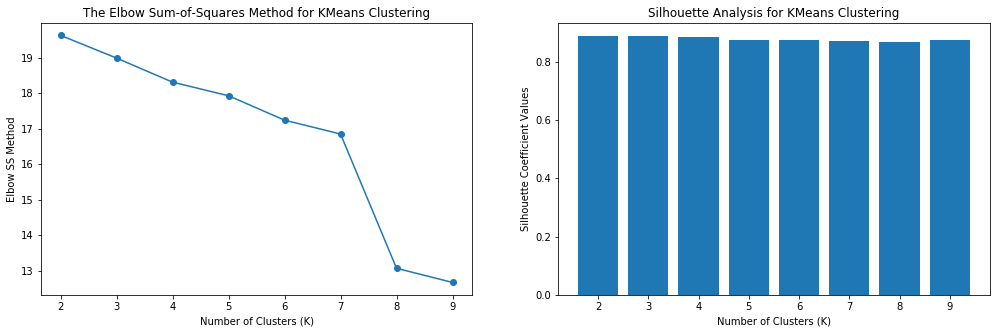

In [8]:
### Plot SS Elbow results to the left and Silhouette analysis to the right
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Elbow Analisys Plot: clusters vs inertias
ax1.plot(k_range, ess_scores_vec, '-o')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Elbow SS Method')
ax1.set_xticks(k_range)
ax1.set_title('The Elbow Sum-of-Squares Method for KMeans Clustering')

# Silhouette Analisys Plot: coefficients vs clusters
ax2.bar(list(k_range), s_scores_vec)   
ax2.set_xticks(list(k_range))
ax2.set_xticklabels(list(k_range))
ax2.set_xlabel("Number of Clusters (K)")
ax2.set_ylabel("Silhouette Coefficient Values")
ax2.set_title('Silhouette Analysis for KMeans Clustering')

plt.show()

>>> Agglomerative Clustering silhouette coef: 0.872462570718


,air_store_id,cluster_id,x,y
0,air_00a91d42b08b08d9,1,-8.056759,0.738866
1,air_0164b9927d20bcc3,1,-8.426074,0.105121
2,air_0241aa3964b7f861,1,-8.411854,0.129522


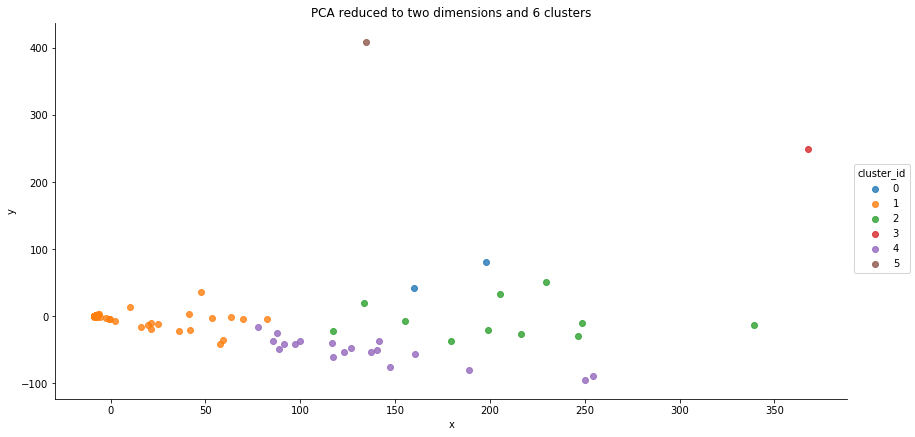

In [9]:
### Visualize clusters
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

matrix_df = get_restaurant_matrix()

# Define the number of clusters (restaurants)
N = 6

# Compute KMeans Clustering
# model = KMeans(n_clusters=N, random_state=8)       
# labels = model.fit_predict(matrix_df)
# print('>>> KMeans Clustering silhouette coef:', silhouette_score(matrix_df, labels))            # score: 0.247566398619

# Compute Agglomerative Clustering
model = AgglomerativeClustering(n_clusters=N, linkage='ward')
model.fit(matrix_df)
labels = model.labels_
print('>>> Agglomerative Clustering silhouette coef:', silhouette_score(matrix_df, labels))     # score: 0.107796894178

# Compute Spectral Clustering
# model = SpectralClustering(n_clusters=N)
# model.fit(matrix_df)
# labels = model.labels_
# print('>>> Spectral Clustering silhouette coef:', silhouette_score(matrix_df, labels))          # score: -0.0180766974492

# reduce the dimensionality of clustering data to 2 components
pca = PCA(n_components=2)
pca.fit(matrix_df)
pca_features = pca.transform(matrix_df)

# create output df
cluster_df = pd.DataFrame()
cluster_df['air_store_id'] = matrix_df.index
cluster_df['cluster_id'] = labels
cluster_df['x'] = pca_features[:,0]
cluster_df['y'] = pca_features[:,1]

display(cluster_df.head(3))

# Draw scatter plot
sns.lmplot(data=cluster_df, x='x', y='y', hue='cluster_id', fit_reg=False, legend=True, size=6, aspect=2)
ax = plt.gca()
ax.set_title('PCA reduced to two dimensions and ' + str(N) + ' clusters')
plt.show()

In [10]:
# Add a cluster_id for every restaurant
short_df = pd.merge(short_df, cluster_df[['air_store_id', 'cluster_id']], on='air_store_id', how='left')
#display(short_df[short_df['cluster_id'] == 2].tail())

### 2.3 Feature Creation: store the geografical distance between the restaurant and the most distant restaurant

In [11]:
short_df['max_lat_dist'] = short_df['latitude'].max() - short_df['latitude']
short_df['max_long_dist'] = short_df['longitude'].max() - short_df['longitude']

### 2.4 Feature Creation: convert restaurant ID's into numeric variables

**Do not use this!** Since RFECV dismissed `'air_store_id'` as an encoded variable, we are not using it.

In [12]:
# Convert 'air_store_id' categorical feature into an encoded variable
# from sklearn.preprocessing import LabelEncoder
# label_enc = LabelEncoder()
# label_enc.fit(short_df['air_store_id'])
# short_df['air_store_id_enc'] = label_enc.transform(short_df['air_store_id'])  # transform categories into integers

### 2.6 Update missing `'reservations'`

Many reservation values are missing (-1). Given that this variable has a lot on influence in our model, can we predict some reservation data just by looking into other features (visit_date/visitors/geographical coord)?

In [13]:
# TODO

### 2.7 Feature Selection: check correlation between `short_df` features

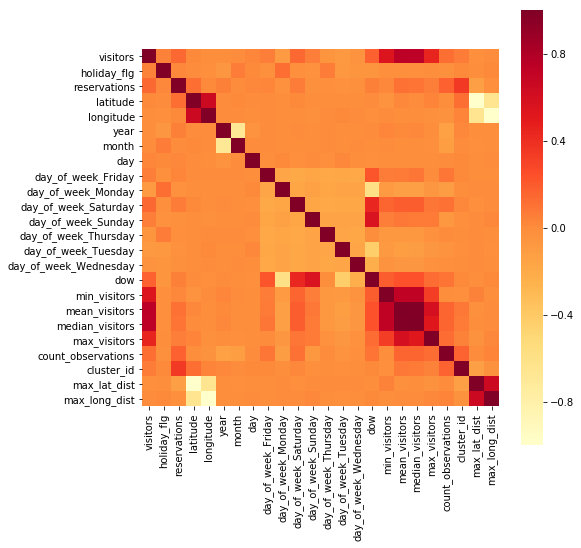

In [14]:
# Plot correlation between different features
plt.figure(figsize=(8, 8))
sns.heatmap(short_df.corr(), square=True, cmap='YlOrRd')  # RdBu_r, YlOrRd
plt.plot()
plt.show()

Generate the list of features used for linear regression:

In [15]:
# get_features(): returns a list of all column names used as features
def get_features():
    feature_names = short_df.columns.values.tolist()
    feature_names.remove('visitors')
    feature_names.remove('visit_date')
    feature_names.remove('air_store_id')
#     feature_names.remove('genre_name')
#     feature_names.remove('cluster_id')
#     feature_names.remove('latitude')
#     feature_names.remove('longitude')
    return feature_names

print('>>> Features =\n', get_features())

>>> Features =
 ['holiday_flg', 'reservations', 'latitude', 'longitude', 'year', 'month', 'day', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'cluster_id', 'max_lat_dist', 'max_long_dist']


### 2.8 Feature Selection (Univariate): evaluate features based on the level of association with its target

`SelectPercentile()` provides an automatic procedure for keeping only a certain percentage of the best, associated features. The main metrics for association for regression purposes is `f_regression`, used only for numeric targets.

Apart from applying a direct selection of the top percentile associations, SelectPercentile can also rank the best variables to make it easier to decide at what percentile to exclude a feature from participating in the learning process. 

Using the level of association output helps you to choose the most important variables for your machine-learning model, but you should watch out for these possible problems:

- Some variables with high association could also be highly correlated, introducing duplicated information, which acts as noise in the learning process.
- Some variables may be penalized, especially binary ones (variables indicating a status or characteristic using the value 1 when it is present, 0 when it is not). 

The higher the F-score, the more associated with the target variable that feature is.

In [16]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

feature_names = get_features()
X = short_df[feature_names]
y = short_df.visitors

selector_f = SelectPercentile(f_regression, percentile=25)
selector_f.fit(X,y)

zipped_list = zip(feature_names, selector_f.scores_)
zipped_list = sorted(zipped_list, key=lambda x: x[1])

# Print most important features first:
for feature, score in reversed(zipped_list):
    print('>>> F-score: %3.2f \tfor feature %s ' % (score, feature))

>>> F-score: 326633.33 	for feature mean_visitors 
>>> F-score: 308867.25 	for feature median_visitors 
>>> F-score: 109247.04 	for feature min_visitors 
>>> F-score: 66054.53 	for feature max_visitors 
>>> F-score: 8535.30 	for feature dow 
>>> F-score: 5564.14 	for feature reservations 
>>> F-score: 5320.88 	for feature day_of_week_Saturday 
>>> F-score: 3754.15 	for feature count_observations 
>>> F-score: 2008.97 	for feature day_of_week_Monday 
>>> F-score: 1778.92 	for feature day_of_week_Tuesday 
>>> F-score: 1058.36 	for feature cluster_id 
>>> F-score: 938.31 	for feature day_of_week_Sunday 
>>> F-score: 839.61 	for feature day_of_week_Friday 
>>> F-score: 703.73 	for feature day_of_week_Thursday 
>>> F-score: 526.54 	for feature day_of_week_Wednesday 
>>> F-score: 443.92 	for feature holiday_flg 
>>> F-score: 187.03 	for feature day 
>>> F-score: 43.63 	for feature max_lat_dist 
>>> F-score: 43.63 	for feature latitude 
>>> F-score: 8.17 	for feature max_long_dist 
>>> F-scor

### 2.9 Feature Selection (Univariate): choose features based on their effective contribution

Automatically reduce the number of features involved in a learning model on the basis of their effective contribution to the performance measured by the error measure.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from itertools import compress

reg = LinearRegression(normalize=True) 
selector = RFECV(estimator=reg, cv=5, scoring='neg_mean_squared_error')
selector.fit(X, y)

print('>>> Optimal number of features: %d' % selector.n_features_)
print('\n>>> Features:\n', feature_names)
print('\n>>> Optimal Features:\n', list(compress(feature_names, selector.support_)))

>>> Optimal number of features: 22

>>> Features:
 ['holiday_flg', 'reservations', 'latitude', 'longitude', 'year', 'month', 'day', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'cluster_id', 'max_lat_dist', 'max_long_dist']

>>> Optimal Features:
 ['holiday_flg', 'reservations', 'latitude', 'longitude', 'year', 'month', 'day', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors', 'count_observations', 'cluster_id', 'max_lat_dist', 'max_long_dist']


As a result from the feature selection process, we should update the function `get_features()` implemented above to reflect these preferences.

# 3. Linear Regression
Linear Regression, Ridge and Lasso had identical scores in the Kaggle Submission System, even after tuning hyper-parameters.

### 3.1 Split Data into Train and Test Sets

In [18]:
from sklearn.model_selection import train_test_split

feature_names = get_features()

X = short_df[feature_names]
y = short_df.visitors.values.reshape(-1, 1)

# 30% of the data is the hold-out set for the final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

### 3.2 Cross-Validation: Linear Regression

Remember: model performance is dependent on way the data is split and it does not represent well the model’s ability to generalize.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression(normalize=True) 
cv_results = cross_val_score(reg, X, y, cv=5) 

print('>>> CV Score results:', cv_results)             #  [ 0.54361827  0.54679412  0.57948773  0.57967388  0.57246542]
print('>>> CV Score (mean):', np.mean(cv_results))     #  0.564407884194

>>> CV Score results: [ 0.54439435  0.54728485  0.57947967  0.57984888  0.57285888]
>>> CV Score (mean): 0.564773323985


### 3.3 Cross-Validation: Ridge (regularized regression)

Linear regression minimizes a loss function. It chooses a coeﬃcient for each feature variable. Large coeﬃcients can lead to overﬁtting. Penalizing large coeﬃcients is called *regularization*.

In [20]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

#params = [ {'alpha': np.logspace(-3, 3, 7)} ]
params = [ {'alpha': [11.3, 11.2, 11.1, 11, 10.9, 10, 9]} ]

ridge_cv = GridSearchCV(estimator=Ridge(), param_grid=params, cv=5, verbose=0, return_train_score=True)
ridge_cv.fit(X_train, y_train) 

print('>>> CV Best parameters:', ridge_cv.best_params_)
#print('>>> CV Best alpha:', ridge_cv.best_estimator_.alpha)
print('>>> CV Best Score:', ridge_cv.best_score_)     # 0.567895269276

>>> CV Best parameters: {'alpha': 11.3}
>>> CV Best Score: 0.568273025532


### 3.4 Cross-Validation: Lasso  (regularized regression)

In [21]:
from sklearn.linear_model import Lasso

#params = [ {'alpha': np.logspace(-3, 3, 7)} ]
params = [ {'alpha': [0.001, 0.0005, 0.0004]} ]

lasso_cv = GridSearchCV(estimator=Lasso(), param_grid=params, cv=5, verbose=0, return_train_score=True)
lasso_cv.fit(X_train, y_train) 

print('>>> CV Best parameters:', lasso_cv.best_params_)
#print('>>> CV Best alpha:', lasso_cv.best_estimator_.alpha)
print('>>> CV Best Score:', lasso_cv.best_score_)     # 0.56791387196

>>> CV Best parameters: {'alpha': 0.001}
>>> CV Best Score: 0.56827378428


### 3.5 Visualize Coefficients for Feature Selection
Plot the coefficients from Linear Regression, Ridge and Lasso for comparison.

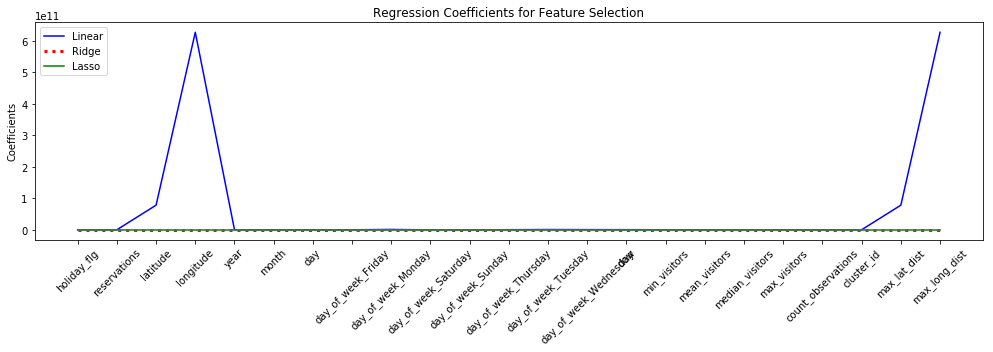

In [22]:
import operator
from functools import reduce

x_width = range(len(feature_names))

reg_coef = LinearRegression().fit(X_train, y_train).coef_
reg_coef = reduce(operator.concat, reg_coef)                           # flat the array: converts [[ 1, 5 ]] into [ 1, 5 ]
ridge_coef = reduce(operator.concat, ridge_cv.best_estimator_.coef_)   # flat the array
lasso_coef = lasso_cv.best_estimator_.coef_

# plot linear regression, ridge and lasso coefficients
plt.figure(figsize=(17,4))
plt.plot(x_width, reg_coef, color='blue', label='Linear') 
plt.plot(x_width, ridge_coef, color='red', label='Ridge', linestyle='dotted', linewidth=3)
plt.plot(x_width, lasso_coef, color='green', label='Lasso')

plt.xticks(x_width, feature_names, rotation=45) 
plt.ylabel('Coefficients') 
plt.title('Regression Coefficients for Feature Selection')
plt.legend()

# draw a gray line that crosses Y at zero (origin)
horiz_line_data = np.array([0 for i in x_width])
xs = [i for i in x_width]
plt.plot(xs, horiz_line_data, color='gray', alpha=0.5)

plt.show()

### 3.6 Compare Actual Visitation Data vs Predicted

>>> Intercept    = [  2.24100363e+13] 
>>> Coefficients = [[  3.72646081e+00   3.07240991e-01   4.69297708e+12  -1.34173233e+12
   -7.64158166e-01  -4.81906571e-02   5.31018237e-02   1.95977202e+13
   -3.54215694e+13   3.33525426e+13   4.71073650e+13   5.84289779e+12
   -2.16667470e+13  -7.91192460e+12  -1.37548224e+13   9.84678479e-03
    9.71586351e-01   1.71688004e-02   1.56164333e-03  -1.30782747e-02
   -6.60749407e-01   4.69297708e+12  -1.34173233e+12]]

>>> Score: 0.571234344856
>>>  RMSE: 11.0879361041


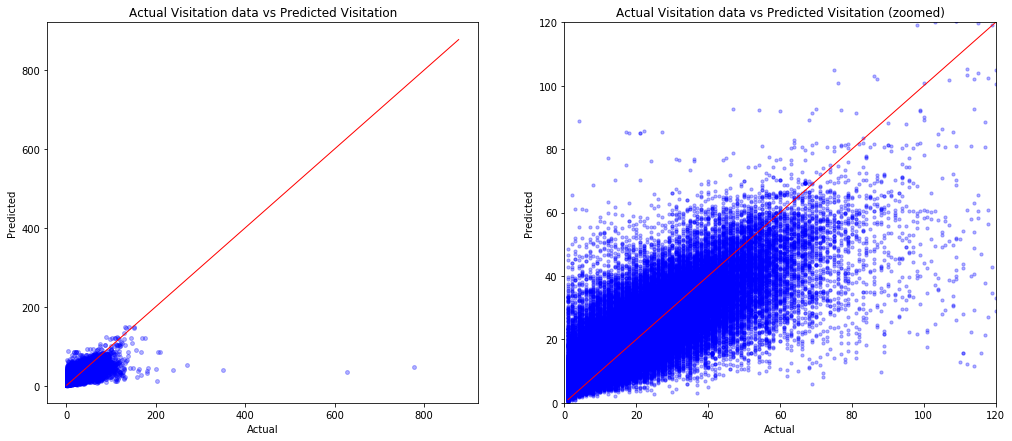

In [23]:
from sklearn import metrics

# Fit the model to the data
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('>>> Intercept    =', reg.intercept_, '\n>>> Coefficients =', reg.coef_)
print('\n>>> Score:', reg.score(X_test, y_test))                         # Score: 0.566365056363
print('>>>  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #  RMSE: 11.1507185793

### Setup plots to compare visitation data
plt.figure(figsize=(17,7))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, s=15, alpha=0.3, color='blue') 
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
plt.title('Actual Visitation data vs Predicted Visitation')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, s=10, alpha=0.3, color='blue') 
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
plt.title('Actual Visitation data vs Predicted Visitation (zoomed)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(xmin=0, xmax=120)
plt.ylim(ymin=0, ymax=120)

plt.show()

# 4. Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
from time import time

# report(): prints detailed information about the 3 best configurations
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    print("*** TOP 3 ***")
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("* Model with rank: {0}".format(i))
            print("* Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("* Parameters: {0}".format(results['params'][candidate]))
            print("")
            

# runRandomForestGridSearch(): uses GridSearchCV() to evaluate the best parameters and prints results using report()
def runRandomForestGridSearch(X, y):
    print('>>> Running Random Forest... (ETA: 2 min.)')

    params = {
        "n_estimators": np.arange(100, 500, 100),
        "max_depth": np.arange(6, 14, 1),
        'max_features': ['log2'],    # 'log2', 'sqrt', 'auto'
        "min_samples_split": np.arange(3,10),
        "min_samples_leaf": [4, 5, 6, 7],
        "bootstrap": [True]
    }

    rf = RandomForestRegressor(oob_score=False)
    rf_cv = GridSearchCV(estimator=rf, param_grid=params, cv=3, n_jobs=7, verbose=2)

    start = time()
    rf_cv.fit(X, y)

    print('>>> Running time %.2f secs for %d parameter settings' % (time() - start, len(rf_cv.cv_results_['params'])))
    print('>>> CV Best parameters:', rf_cv.best_params_)
    print('>>> CV Best Score:', rf_cv.best_score_)
    
    print('')
    report(rf_cv.cv_results_)
    print('>>> Done!')    

In [25]:
from sklearn.ensemble import RandomForestRegressor
from time import time

# Invoke the function below to fine tune hyper-params. WARNING: it will take at least 2 hours to finish.
# runRandomForestGridSearch(X_train, y_train.flatten())

In [26]:
rf_model = RandomForestRegressor(n_jobs=6, bootstrap=True, max_depth=13, max_features='log2', min_samples_leaf=4, min_samples_split=5, n_estimators=400)
rf_model.fit(X_train, y_train.flatten())
y_pred = rf_model.predict(X_test)

print('>>> Score:', rf_model.score(X_test, y_test)) # 0.579330194452

>>> Score: 0.580947682885


### 4.1 Visualize Feature Importances

,mean_visitors,median_visitors,max_visitors,min_visitors,month,day,count_observations,dow,reservations,holiday_flg,...,max_lat_dist,day_of_week_Saturday,year,cluster_id,day_of_week_Monday,day_of_week_Sunday,day_of_week_Tuesday,day_of_week_Friday,day_of_week_Thursday,day_of_week_Wednesday
values,0.369473,0.278426,0.139418,0.102648,0.015175,0.015125,0.012584,0.012325,0.011921,0.005947,...,0.004875,0.004132,0.003882,0.003457,0.001237,0.001082,0.000907,0.00072,0.000703,0.000481


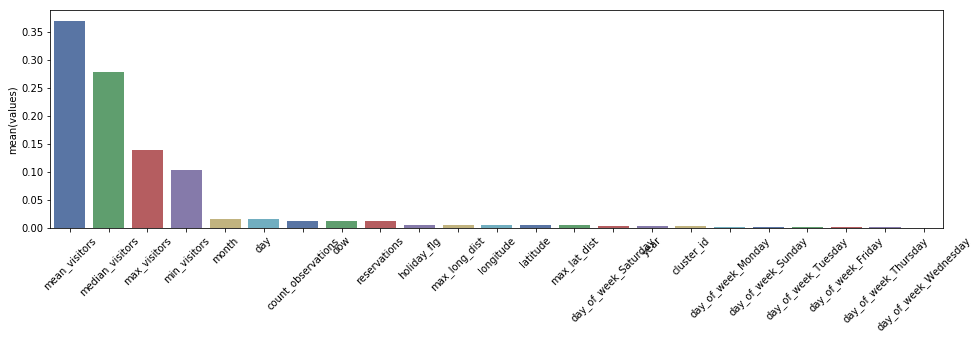

In [27]:
feature_import = pd.DataFrame(data=rf_model.feature_importances_, index=feature_names, columns=['values'])
feature_import.sort_values(['values'], ascending=False, inplace=True)
feature_import = feature_import.transpose()
display(feature_import)

plt.figure(figsize=(16,4))
#feature_import.iloc[0].plot(kind='bar')
g = sns.barplot(data=feature_import, palette='deep')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_ylabel('mean(values)')
plt.show()

### 4.2 Compare Actual Visitation Data vs Predicted

>>> Score: 0.571234344856
>>>  RMSE: 10.9616225251


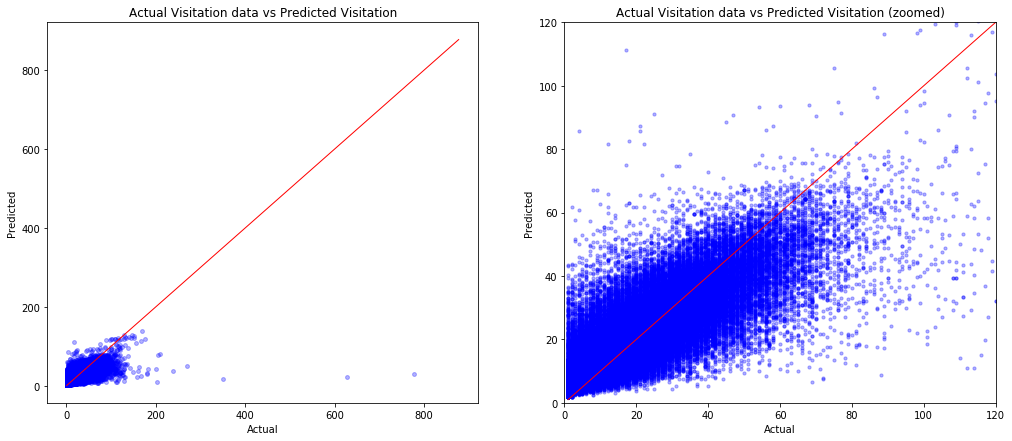

In [28]:
print('>>> Score:', reg.score(X_test, y_test))                           # Score: 0.566365056363
print('>>>  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #  RMSE: 10.9827573818

### Setup plots to compare visitation data
plt.figure(figsize=(17,7))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, s=15, alpha=0.3, color='blue') 
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
plt.title('Actual Visitation data vs Predicted Visitation')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, s=10, alpha=0.3, color='blue') 
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
plt.title('Actual Visitation data vs Predicted Visitation (zoomed)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(xmin=0, xmax=120)
plt.ylim(ymin=0, ymax=120)

plt.show()

# 5. Gradient Boosting Regression

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

def runGBRGridSearch(X, y):
    print('>>> Gradient Boosting Regression... (ETA: 2 min.)')
    
    params = { 
        'n_estimators': [94, 95, 100],
         'learning_rate': [0.05, 0.06, 0.07, 0.08],
         'max_depth': [6, 7, 8],
         'min_samples_split': [2, 3],
         'min_samples_leaf': [2, 3],
         'max_features': [0.6, 0.5, 0.4]
    }

    gbr_cv = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, max_depth=8, max_features='sqrt', subsample=0.8, random_state=10), 
                          param_grid=params, cv=3, n_jobs=6, verbose=2)

    start = time()
    gbr_cv.fit(X, y)

    print('>>> Running time %.2f secs for %d parameter settings' % (time() - start, len(gbr_cv.cv_results_['params'])))
    print('>>> CV Best parameters:', gbr_cv.best_params_)
    print('>>> CV Best Score:', gbr_cv.best_score_)
    
    print('')
    report(gbr_cv.cv_results_)
    print('>>> Done!')   

In [30]:
# Invoke the function below to fine tune hyper-params. WARNING: it might take several hours to finish.
# runGBRGridSearch(X_train, y_train.flatten())

# 6. Kaggle Submission

Given that **regularized regression** didn't help to improve the model in a significant way, I decided to not use it for the time being.

In the current approach:
- `air_store_id` was encoded to be used as a feature, but this dind't improve the score at all;
- To get equivalent `holiday_flg` values for the submission dates, I retrieved the same holidays from the year before;
- `day_of_week` was encoded as a dummy variable to be used in regression;
- `reservation` data slightly improved the score, so we are using it;

All visit dates from `sample_submission.csv` are new dates. In other words, there is no visitation data in our model for the same period of time.

**Kaggle Submissions History:**
- **Score 0.723**: linear regression, Agglomerative (2 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.732**: random forest, Agglomerative (2 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.738**: gradient boosting, Agglomerative (2 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.746**: linear regression, Agglomerative (4 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.747**: linear regression, KMeans (2 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.773**: linear regression, KMeans (4 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.794**: linear regression, KMeans (6 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.829**: linear regression, KMeans (5 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.833**: linear regression, KMeans (7 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.854**: linear regression, KMeans (8 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.859**: linear regression, KMeans (3 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.859**: linear regression, reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.866**: linear regression, w/o reservations, holidays from 2016, w/o restaurant ID encoding;

In [31]:
# load_submission_file(): reads sample_submissions.csv and returns a DataFrame with extra columns parsed from 'id'
def load_submission_file():
    sub_df = pd.read_csv('data/sample_submission.csv')    
    
    # parse store_id from: air_00a91d42b08b08d9_2017-04-23
    sub_df['air_store_id'] = sub_df.id.map(lambda x: '_'.join(x.split('_')[:-1]))  
    
    # parse date from: from: air_00a91d42b08b08d9_2017-04-23
    sub_df['visit_date'] = sub_df.id.map(lambda x: x.split('_')[2])
    
    # erase visitors column
    sub_df.drop('visitors', axis=1, inplace=True)    
    #sub_df.drop('id', axis=1, inplace=True) 
          
    return sub_df

In [32]:
# adj_prediction_features(): adjusts the features of the input DataFrame to match what's required for prediction.
# Current features are:
#    holiday_flg, reservations, year, month, day, day_of_week_Friday, day_of_week_Monday, 
#    day_of_week_Saturday, day_of_week_Sunday, day_of_week_Thursday, day_of_week_Tuesday, day_of_week_Wednesday
#
def adj_prediction_features(sub_df):    
    
    # To fill the column 'holiday_flg', pretend submission's visit_date is from the previous year and copy those holidays
    sub_df['visit_date'] = sub_df['visit_date'].str.replace('2017','2016')
    sub_df.visit_date = pd.to_datetime(sub_df.visit_date)

    # Drop duplicates in holidays_df to avoid adding more rows to the merged Dataframe
    holidays_df = short_df[['visit_date', 'holiday_flg']]
    holidays_df = holidays_df.drop_duplicates(subset=['visit_date'])

    ### Add HOLIDAY_FLG: fill with holidays from 2016
    sub_df = pd.merge(sub_df, holidays_df[['visit_date', 'holiday_flg']], on='visit_date', how='left')

    # Convert 'visit_date' to string and revert back to the original year (2017)
    sub_df['visit_date'] = sub_df['visit_date'].dt.strftime('%Y-%m-%d')
    sub_df['visit_date'] = sub_df['visit_date'].str.replace('2016','2017')
    sub_df.visit_date = pd.to_datetime(sub_df.visit_date)

    # Add MAX_LAT_DIST, MAX_LONG_DIST, LATITUDE and LONGITUDE
    geo_df = short_df[['air_store_id', 'max_lat_dist', 'max_long_dist', 'latitude', 'longitude']].drop_duplicates()
    sub_df = pd.merge(sub_df, geo_df, how='left', on=['air_store_id']) 
    
    # Add 'DAY_OF_WEEK' column
    import calendar
    sub_df['day_of_week'] = sub_df['visit_date'].apply(lambda x: (calendar.day_name[x.weekday()]))
    sub_df = pd.get_dummies(sub_df, columns=['day_of_week'])

    # Add YEAR, MONTH, DAY columns
    sub_df['year'] = sub_df['visit_date'].dt.year
    sub_df['month'] = sub_df['visit_date'].dt.month
    sub_df['day'] = sub_df['visit_date'].dt.day
    
    # Add DOW (Day Of the Week)
    sub_df['dow'] = sub_df['visit_date'].apply(lambda x: x.weekday())  # Monday=0, Sunday=6
    
    # Add visitor-statistics    
    stats_df = short_df[['air_store_id','dow', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations']]
    stats_df = stats_df.drop_duplicates()    
    sub_df = pd.merge(sub_df, stats_df, how='left', on=['air_store_id','dow'])          

    # At this point, some restaurants will have NaNs in visitor-statistics columns because 
    # there was no training data of that restaurant for that particular weekday (ex: Monday).
    # Check with: 
    #    display(short_df[(short_df.air_store_id == 'air_0164b9927d20bcc3') & (short_df.dow == 6)].head())
    # Print rows with NaN values: 
    #    missing_stats_df = sub_df[sub_df.isnull().any(axis=1)]
    #
    # But here is how we are going to handle it:
#     sub_df.fillna(0, inplace=True)           # Both alternatives don't change the score (0.546)
    sub_df = sub_df.fillna(sub_df.mean())
        
    ### Add RESERVATIONS column: careful, there are many occurences for the same month and day
    # fill reservations with the average from that month/day. Note: ruined the score by +0.001
    ###      
    tmp_df = short_df.groupby(['month', 'day']).mean().reset_index()[['month', 'day', 'reservations']]
    sub_df = pd.merge(sub_df, tmp_df, on=['month', 'day'], how='left')

    # Add AIR_STORE_ID_ENC: convert categorical variable into encoded variable
    #sub_df['air_store_id_enc'] = label_enc.transform(sub_df['air_store_id'])  # transform categories into integers

    # Add CLUSTER_ID from the clustering process
    sub_df = pd.merge(sub_df, cluster_df[['air_store_id', 'cluster_id']], on='air_store_id', how='left')

    # Delete unecessary columns
    del sub_df['air_store_id']
    del sub_df['visit_date'] 
    
    return sub_df

In [33]:
### Load sample_submissions.csv into the DataFrame that's used for submission on Kaggle
sub_df = load_submission_file()
print('>>> sub_df (original) shape=', sub_df.shape)
# display(sub_df.head(2))

### Do some magic and create the necessary features for prediction
sub_df = adj_prediction_features(sub_df)
print('>>> sub_df (features) shape=', sub_df.shape)
# display(sub_df.head(2))

### Use training data from the short Restaurant dataset
X = short_df[feature_names]
y = short_df.visitors.values.reshape(-1, 1)

### Alternative 1 - Kaggle: 0.723
### Fit a Linear regression model and use it to predict the amount of visitors for each restaurant
model = LinearRegression()
#model = Lasso(alpha=0.0004)
#model = Ridge(alpha=11.2)
model.fit(X, y)

#model = GradientBoostingRegressor(n_estimators=200, random_state=7, learning_rate=0.1, max_depth=8)
# model = GradientBoostingRegressor(n_estimators=95, learning_rate=0.07, max_depth=7, max_features=0.5, min_samples_leaf=3, min_samples_split=3)
# %time model.fit(X, y.flatten())


### Alternative 2 - Kaggle: 0.732
### Fit a Random Forest regression model and use it to predict the amount of visitors for each restaurant
# model = RandomForestRegressor(n_jobs=6, bootstrap=True, max_depth=13, max_features='log2', min_samples_leaf=4, min_samples_split=5, n_estimators=400)
# model.fit(X, y.flatten())

# Store prediction as 'visitors'
print('>>> Features:\n', feature_names)
sub_df['visitors'] = model.predict(sub_df[feature_names])

print('\n>>> Features + Prediction:')
display(sub_df.head(2))  

### The final dataset must have only 2 columns: id and visitors
final_df = sub_df[['id', 'visitors']]

### Save the result to disk as 'prediction.csv'
final_df.to_csv('prediction.csv', index=False)
print('\n>>> Submission file', final_df.shape, 'saved as: prediction.csv')
display(final_df.tail(5))

>>> sub_df (original) shape= (32019, 3)
>>> sub_df (features) shape= (32019, 24)
>>> Features:
 ['holiday_flg', 'reservations', 'latitude', 'longitude', 'year', 'month', 'day', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'cluster_id', 'max_lat_dist', 'max_long_dist']

>>> Features + Prediction:


,id,holiday_flg,max_lat_dist,max_long_dist,latitude,longitude,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,...,day,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,reservations,cluster_id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0,8.326629,4.519803,35.694003,139.753595,0,0,0,1,...,23,6,2.0,2.000000,2.0,2.0,1.0,-0.458472,1,2.828125
1,air_00a91d42b08b08d9_2017-04-24,0,8.326629,4.519803,35.694003,139.753595,0,1,0,0,...,24,0,1.0,22.457143,19.0,47.0,35.0,-0.958904,1,22.148438



>>> Submission file (32019, 2) saved as: prediction.csv


,id,visitors
32014,air_fff68b929994bfbd_2017-05-27,7.656250
32015,air_fff68b929994bfbd_2017-05-28,4.625000
32016,air_fff68b929994bfbd_2017-05-29,4.343750
32017,air_fff68b929994bfbd_2017-05-30,5.203125
32018,air_fff68b929994bfbd_2017-05-31,5.187500
